# Visualize local ancestry: chromosome section

Kynon J Benjamin  
2024-07-03

# 1. Load packages

In [1]:
import session_info
import pandas as pd
import seaborn as sns
from pyhere import here
import matplotlib.pyplot as plt
from rfmix_reader import read_rfmix

# 2. Load data

In [2]:
prefix_path = here("input/real_data/_m/")
binary_dir = here("real_data/gpu_version/_m/binary_files/")
loci, rf_q, admix = read_rfmix(prefix_path, binary_dir=binary_dir)

GPU 0: NVIDIA A100 80GB PCIe
  Total memory: 79.15 GB
  CUDA capability: 8.0
Multiple files read in this order: ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9']

Mapping fb files:   0%|          | 0/22 [00:00<?, ?it/s]Mapping fb files:   5%|▍         | 1/22 [00:00<00:03,  6.27it/s]Mapping fb files:   9%|▉         | 2/22 [00:00<00:02,  7.89it/s]Mapping fb files:  18%|█▊        | 4/22 [00:00<00:01,  9.23it/s]Mapping fb files:  27%|██▋       | 6/22 [00:00<00:01, 10.93it/s]Mapping fb files:  36%|███▋      | 8/22 [00:00<00:01, 12.61it/s]Mapping fb files:  45%|████▌     | 10/22 [00:00<00:00, 13.72it/s]Mapping fb files:  55%|█████▍    | 12/22 [00:01<00:01,  9.05it/s]Mapping fb files:  68%|██████▊   | 15/22 [00:01<00:00, 12.75it/s]Mapping fb files:  77%|███████▋  | 17/22 [00:01<00:00,  9.98it/s]Mapping fb files:  86%|████████▋ | 19/22 [00:01<00:00,  8.68it/s]Mapping fb files:  95%|█████████▌| 21/22 [00:02<00:00,  8.49it/s]Mapping fb files: 100%|██████████| 22/22 [00:02<00:00,  8.99it/s]

# 3. Visualize chromosome global ancestry

## 3.1 Organize chromosome

In [3]:
chrom_order = [f'chr{i}' for i in range(1, 23)]
rf_q_pandas = rf_q.to_pandas() # Convert cuDF to pandas DataFrame
rf_q_pandas['chrom'] = pd.Categorical(rf_q_pandas['chrom'], 
                                      categories=chrom_order, ordered=True)
rf_q_sorted = rf_q_pandas.sort_values('chrom')

## 3.2 Create and save the plot

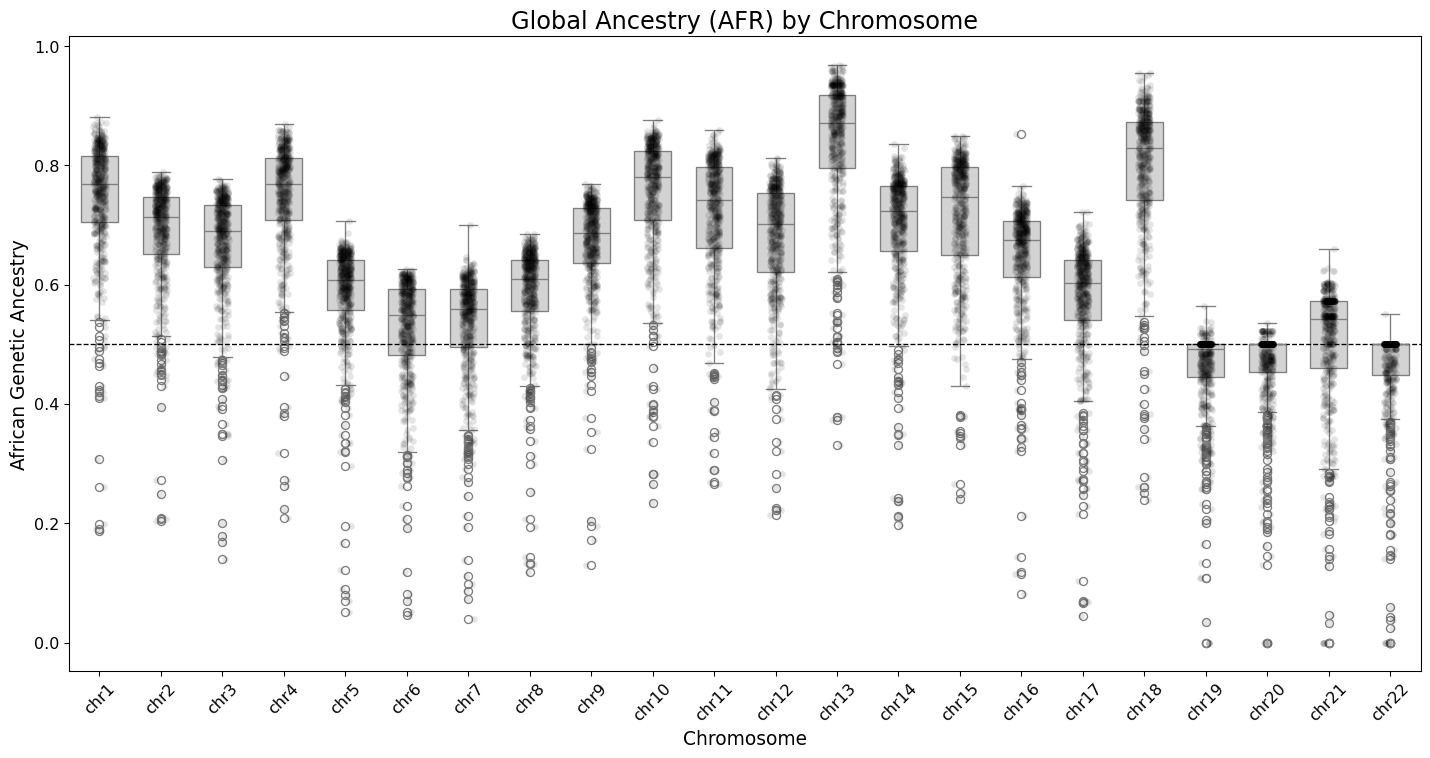

In [4]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='chrom', y='AFR', data=rf_q_sorted, 
            color='lightgray', width=0.6)
sns.stripplot(x='chrom', y='AFR', data=rf_q_sorted, 
              color='black', alpha=0.1, jitter=True)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
plt.title('Global Ancestry (AFR) by Chromosome', fontsize=18)
plt.xlabel('Chromosome', fontsize=14)
plt.ylabel('African Genetic Ancestry', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

## 3.3 Mean and median African ancestry proportion

In [5]:
rf_q_sorted.groupby("chrom").agg({"AFR": ["mean", "median"]})

In [6]:
print(rf_q_sorted.AFR.mean(), rf_q_sorted.AFR.median())

0.6363452039405462 0.6444000000000001

**Select chromosome with:** \* High African Ancestry – chromosome 13 \*
Low African Ancestry – chromosome 19 \* Average African Ancestry –
chromosome 16

# 4. Prepare data

## 4.1 Helper functions

In [7]:
import dask.dataframe as dd
from multiprocessing import cpu_count

In [8]:
try:
    from torch.cuda import is_available
except ModuleNotFoundError as e:
    print("Warning: PyTorch is not installed. Using CPU!")
    def is_available():
        return False


In [9]:
def _get_pops(rf_q):
    return rf_q.drop(["sample_id", "chrom"], axis=1).columns.values


def _get_sample_names(rf_q):
    if is_available():
        return rf_q.sample_id.unique().to_arrow()
    else:
        return rf_q.sample_id.unique()

## 4.2 Define column names

In [10]:
pops = _get_pops(rf_q)
sample_ids = _get_sample_names(rf_q)

## 4.3 Convert data to dask dataframe

In [11]:
parts = cpu_count()
ncols = admix.shape[1] // len(pops)
ddf = dd.from_pandas(loci.to_pandas(), npartitions=parts)
data_matrix = admix[:, :ncols] # select the first pop only (pop2 is just 1-pop1)
dask_df = dd.from_dask_array(data_matrix, columns=sample_ids)

## 4.4 Combine loci with haplotype data

In [12]:
ddf = dd.concat([ddf, dask_df], axis=1)
del dask_df # remove for memory consumption

## 4.5 Select chromosomes

In [13]:
chrom13 = ddf[ddf["chromosome"] == "chr13"]
chrom16 = ddf[ddf["chromosome"] == "chr16"]
chrom19 = ddf[ddf["chromosome"] == "chr19"]
del ddf

# 5. Plot a section of each chromosome

## 5.1 Helper function

In [14]:
from numpy import random

In [15]:
def select_random_section(df, section_size=10000):
    # Get the minimum and maximum positions
    min_pos = df['physical_position'].min().compute()
    max_pos = df['physical_position'].max().compute()
    # Randomly select a start position
    start_pos = random.randint(min_pos, max_pos - section_size)
    end_pos = start_pos + section_size
    # Filter the DataFrame for the selected section
    section = df[(df['physical_position'] >= start_pos) & (df['physical_position'] < end_pos)]
    ##section = section.melt(id_vars=["chromosome", "physical_position", "i"], 
    ##                       var_name="BrNum", value_name="Haplotypes")
    return section.compute()  # Compute to bring data into memory


def plot_section(df, section_size, fname):
    selected_section = select_random_section(df, section_size)
    selected_section = selected_section.sort_values("physical_position")
    plt.figure(figsize=(12, 3))
    sns.scatterplot(data=selected_section, x='physical_position', y='Br2585', 
                    color='black', legend=False, s=20)
    plt.title(f'Chromosome Section Plot (Positions {selected_section["physical_position"].min()} to {selected_section["physical_position"].max()})', fontsize=16)
    plt.xlabel('Chromosome Position', fontsize=12)
    plt.ylabel('Haplotypes', fontsize=12)
    plt.yticks([0, 1, 2])
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f'local_ancestry.{fname}.pdf', dpi=300, bbox_inches='tight')

## 5.2 Seed for reproducibility

In [16]:
seed_value = 13
random.seed(seed_value)
section_size = 1000000

## 5.3 Plotting

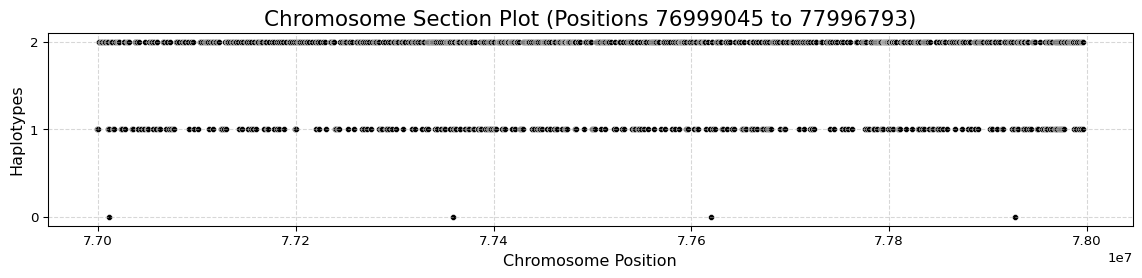

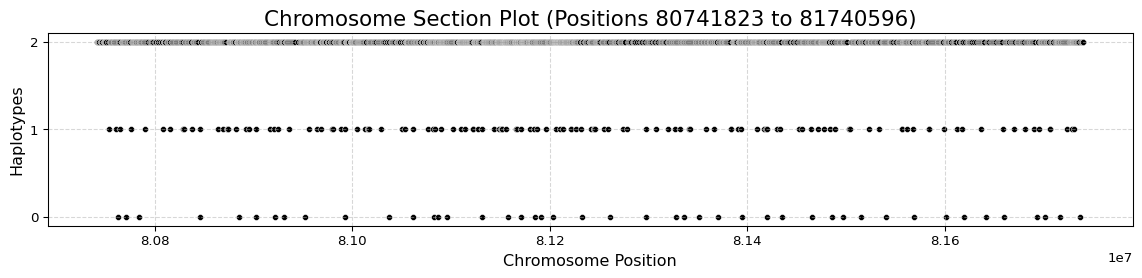

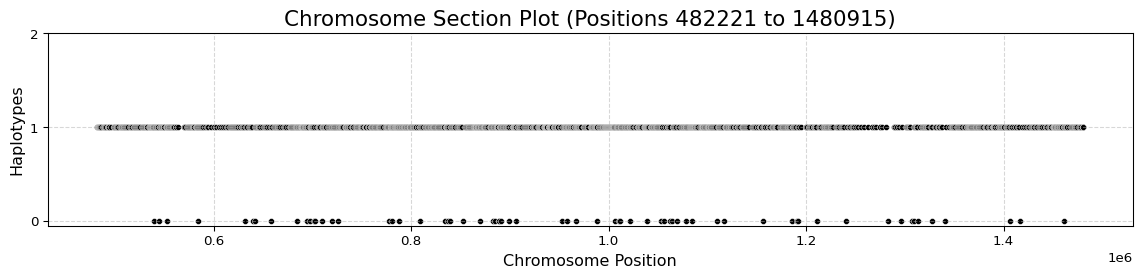

In [17]:
plot_section(chrom13, section_size, "chr13")
plot_section(chrom16, section_size, "chr16")
plot_section(chrom19, section_size, "chr19")

# 6. Session information

In [18]:
session_info.show()

Click to view session information 
 
-----
cudf 24.06.00
dask 2024.6.2
dask_expr 1.1.6
matplotlib 3.7.1
numpy 1.26.4
pandas 2.0.3
pyhere 1.0.0
rfmix_reader 0.1.14
seaborn 0.13.2
session_info 1.0.0
torch 2.3.1+cu121
-----
 
 
 Click to view modules imported as dependencies 
 
PIL 10.3.0
anyio NA
argcomplete NA
arrow 1.2.3
asttokens NA
astunparse 1.6.3
attr 23.2.0
attrs 23.2.0
babel 2.10.3
backcall 0.2.0
cachetools 5.3.3
cairo 1.20.1
certifi 2024.02.02
cffi 1.16.0
chardet 4.0.0
charset_normalizer 3.3.2
click 8.1.2
cloudpickle 2.1.0
comm 0.2.2
cuda 12.4.0
cupy 13.1.0
cupy_backends NA
cupyx NA
cycler 0.10.0
cython_runtime NA
dateutil 2.8.2
debugpy 1.6.3
decorator 5.1.1
defusedxml 0.7.1
distributed 2024.6.2
dot_parser NA
exceptiongroup 1.2.0
executing 0.10.0
fastjsonschema NA
fastrlock 0.8.2
fontTools 4.33.3
fqdn NA
fsspec 2022.7.1
gi 3.40.1
gio NA
glib NA
gobject NA
google NA
gtk NA
idna 2.10
importlib_metadata NA
importlib_resources NA
iniconfig NA
ipykernel 6.15.1
ipywidgets 8.1.2
isoduration NA
jedi 0.19.1
jinja2 3.1.1
json5 NA
jsonpointer 2.3
jsonschema 4.21.1
jsonschema_specifications NA
jupyter_events 0.10.0
jupyter_server 2.13.0
jupyterlab_server 2.25.4
kaleido 0.2.1
kiwisolver 1.4.3
llvmlite 0.42.0
locket NA
lxml 4.9.1
markupsafe 2.1.1
matplotlib_inline 0.1.6
mpl_toolkits NA
msgpack 1.0.4
nbformat 5.4.0
netifaces 0.10.6
numba 0.59.0
numexpr 2.10.1
nvtx NA
optree 0.11.0
overrides NA
packaging 21.3
parso 0.8.3
patsy 0.5.2
pexpect 4.8.0
pickleshare 0.7.5
pkg_resources NA
platformdirs 3.8.0
plotly 5.9.0
pluggy 1.5.0
prometheus_client NA
prompt_toolkit 3.0.30
psutil 5.9.8
ptyprocess 0.7.0
pure_eval 0.2.2
py 1.11.0
pyarrow 16.1.0
pydev_ipython NA
pydevconsole NA
pydevd 2.8.0
pydevd_file_utils NA
pydevd_plugins NA
pydevd_tracing NA
pydot 1.4.2
pygments 2.18.0
pynvml 11.4.1
pyparsing 3.0.9
pytest 8.2.1
pythonjsonlogger NA
pytz 2022.1
rapids_dask_dependency NA
referencing NA
requests 2.31.0
rfc3339_validator 0.1.4
rfc3986_validator 0.1.1
rmm 24.06.00
rpds NA
scipy 1.13.1
send2trash NA
setuptools 70.0.0
six 1.16.0
sniffio 1.2.0
socks 1.7.1
sortedcontainers 2.4.0
sphinxcontrib NA
stack_data 0.4.0
statsmodels 0.14.0
tblib 3.0.0
tenacity NA
tlz 0.12.0
toolz 0.12.0
torchgen NA
tornado 6.2
tqdm 4.66.4
traitlets 5.9.0
typing_extensions NA
uri_template NA
urllib3 1.26.18
wcwidth 0.2.5
webcolors 1.11.1
websocket 1.4.0
yaml 6.0
zict 3.0.0
zipp NA
zmq 25.0.0
zoneinfo NA
zstandard 0.18.0
 
 <!-- seems like this ends pre, so might as well be explicit -->
 
-----
IPython 8.4.0
jupyter_client 8.0.2
jupyter_core 5.2.0
jupyterlab 4.1.5
notebook 7.1.2
-----
Python 3.9.16 (main, Dec 8 2022, 00:00:00) [GCC 11.3.1 20221121 (Red Hat 11.3.1-4)]
Linux-5.14.0-284.11.1.el9_2.x86_64-x86_64-with-glibc2.34
-----
Session information updated at 2024-07-03 15:09